In [3]:
import nrrd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import cv2
import scipy

import SimpleITK as sitk 
import os 
import shutil

import statistics
import pandas as pd


## Get the data from the .xsxl file

In [2]:
columns = ['TAPS_CaseIDs_PreNAT','RECIST_PostNAT', 'Slice_Thickness']
data = pd.read_excel('PDAC-Response_working.xlsx', header=None,names = columns)
data.drop(0, inplace=True) # Remove the header row
data=data.sort_values(by=['TAPS_CaseIDs_PreNAT'])

# # Get the entire datasheet
cases = list(data['TAPS_CaseIDs_PreNAT'])
recistCriteria = list(data['RECIST_PostNAT'])
print(len(recistCriteria))


# # Remove all folders that have >13 slices in the datasheet
# data.drop(data[data['Slice_Thickness'] <= 13].index, inplace = True)
# print(list(data['Slice_Thickness']))
# cases = list(data['TAPS_CaseIDs_PreNAT'])
# recistCriteria = list(data['RECIST_PostNAT'])


85


## Perform preprocessing on multiple images


In [3]:
def window_image_to_adbomen(image, window_center, window_width):
    
    img_max = window_center + int(window_width / 2)
    img_min = window_center - int(window_width / 2)
    return np.clip(image, img_min, img_max)

def centerXYOfImage(overlay_mask, segment_mask, segmentedSlices, padding=25):
    """ 
    Centers the X and Y of the image to crop the image. segmentedSlices is given as an array of z-value slices because the same approach to x_indicies and y_indicies does not work on overlay_segment (works for x and y though)
    """
    x_indices, y_indices, _ = np.where(segment_mask == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2

    width = abs(max_x - min_x) // 2
    height = abs(max_y - min_y) // 2

    
    # Get the dimensions of the cropped image
    start_x = max(0, center_x - width - padding)
    end_x = min(segment_mask.shape[0], center_x + width + padding)
    start_y = max(0, center_y - height - padding)
    end_y = min(segment_mask.shape[1], center_y + height + padding)

    # # Adjust the crop region if it's smaller than 100x100
    # if end_x - start_x < 100:
    #     if start_x == 0:
    #         end_x = min(segment_mask.shape[0], 100)
    #     elif end_x == segment_mask.shape[0]:
    #         start_x = max(0, segment_mask.shape[0] - 100)
    # if end_y - start_y < 100:
    #     if start_y == 0:
    #         end_y = min(segment_mask.shape[1], 100)
    #     elif end_y == segment_mask.shape[1]:
    #         start_y = max(0, segment_mask.shape[1] - 100)

    segmentedSlices = np.sort(np.array(segmentedSlices))
    return overlay_mask[start_x:end_x, start_y:end_y, np.array(segmentedSlices)]

In [4]:
def convertNdArrayToCV2Image(image, resolution = (64,64)):
    """ Converts a numpy array to a cv2 image """
    image = np.array(image, dtype=np.uint8)
    image = cv2.resize(image, resolution)
    return image

def makeAlign(image1,image2):
    image1.SetDirection(image2.GetDirection())
    image1.SetOrigin(image2.GetOrigin())
    image1.SetSpacing(image2.GetSpacing())
    return image1, image2

def isAligned(image1, image2):
    return image1.GetDirection() == image2.GetDirection() and image1.GetOrigin() == image2.GetOrigin() and image1.GetSpacing() == image2.GetSpacing()   

def resampleSizes(wholeHeader, segmentHeader):
    """ 
    Resamples the sitk image to have the same size based on the one with the largest size.
    """
    if wholeHeader.GetSize()[-1] >= segmentHeader.GetSize()[-1]:
        imageLarge = wholeHeader
        imageSmall = segmentHeader
        wholeThenSegmentOrder = True
    else:
        imageLarge = segmentHeader
        imageSmall = wholeHeader 
        wholeThenSegmentOrder = False

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(imageLarge)  
    resample.SetInterpolator(sitk.sitkLinear)  # Choose the interpolation method (sitkLinear, sitkNearestNeighbor, etc.)
    resample.SetDefaultPixelValue(0)  # Set default pixel value for areas outside the original image

    imageSmall = resample.Execute(imageSmall)

    print(f'imageLarge: {imageLarge.GetSize()}')
    print(f'imageSmall: {imageSmall.GetSize()}')
    

    if wholeThenSegmentOrder:
        return imageLarge, imageSmall # whole, then segment
    else:
        return imageSmall, imageLarge # segment, then whole

In [5]:
def twoImageAlignProceess(wholeHeader,segmentHeader,verbose):    

    error = False
    # Check if the images are aligned
    wholeHeader, segmentHeader = makeAlign(wholeHeader, segmentHeader)
    imagesAreAligned = isAligned(wholeHeader, segmentHeader)
    print(f'Are the two images aligned now?: {imagesAreAligned}' if verbose==2 else '',end='')

    if not imagesAreAligned:
        error = True
        return None, None, True
    
    # Set the spacing of the image to 1x1x1mm voxel spacing
    wholeHeader.SetSpacing([1,1,1])
    segmentHeader.SetSpacing([1,1,1])
    imagesSpacingAligned = wholeHeader.GetSpacing() == segmentHeader.GetSpacing() 
    print(f'Are the two images aligned in terms of spacing?: {imagesSpacingAligned}' if verbose==2 else '',end='')

    if not imagesSpacingAligned:
        error = True
        return None, None, True
    

    imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
    print(f'Are the two images aligned in terms of size?: {imagesSizeAligned}' if verbose==2 else '',end='')

    if not imagesSizeAligned:
        wholeHeader, segmentHeader = resampleSizes(wholeHeader, segmentHeader)
        print(f'whole size: {wholeHeader.GetSize()}')
        print(f'segment size: {segmentHeader.GetSize()}')
        imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
        print(f'Are the two images aligned in terms of size now?: {imagesSizeAligned}' if verbose==2 else '',end='')
        if not imagesSizeAligned:
            error = True
            return None, None, True

    
    return wholeHeader, segmentHeader, False

    

In [6]:
def displayCroppedSegmentations(croppedSegment):
    print(f'CroppedSegment shape: {croppedSegment.shape}')
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,croppedSegment.shape[-1] // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    
    rowIdx = 0
    for idx in range(croppedSegment.shape[-1]):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(croppedSegment[:,:,idx], cmap="gray")
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


def displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment):

    maskedWhole = np.ma.masked_where(augmented_segment==1, augmented_whole)
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,len(segmentedSlices) // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(6, 6))
    rowIdx = 0
    for idx in range(len(segmentedSlices)):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(augmented_whole[:,:,segmentedSlices[idx]], cmap="gray")
        axis[rowIdx][idx%columnLen].imshow(augmented_segment[:,:,segmentedSlices[idx]], cmap="Blues", alpha=0.75)
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [7]:
def preprocess(wholeHeader, segmentHeader, verbose=0):
    """
    Preprocesses the wholeHeader and segmentHeader sitk images to be ready for augmentation 
    Verbose = 0: No output
    Verbose = 1: Only the CT scans slices and the array of slices it uses
    Verbose = 2: Everything
    Verbose = 3: Show the segment mask on top of the whole CT scan

    Returns: a np array windowed whole image, a np array cropped segment image to 64x64x[] resolution, and boolean error flag.
    """
    error = False # Error flag to check if there was an error in the preprocessing

    # Align the two images 
    wholeHeader, segmentHeader, error = twoImageAlignProceess(wholeHeader, segmentHeader, verbose) 
    if error:
        return None, None, error
    
    # Convert the images into numpy arrays for further processing, take the transpose as the format is z,y,x
    whole = sitk.GetArrayFromImage(wholeHeader).T
    segment = sitk.GetArrayFromImage(segmentHeader).T

    print(f'Spacing of whole:{whole.shape}' if verbose==2 else '',end='')
    print(f'Spacing of segment:{segment.shape}' if verbose==2 else '',end='')
    
    # Windowing parameters for the abdomen
    ABDOMEN_UPPER_BOUND = 215
    ABDOMEN_LOWER_BOUND = -135
    window_center = (ABDOMEN_UPPER_BOUND+ABDOMEN_LOWER_BOUND) / 2
    window_width = (ABDOMEN_UPPER_BOUND-ABDOMEN_LOWER_BOUND) / 2

    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)

    # Get the slice indices where the segment is present in 
    augmented_segment = segment
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[-1]):
        if len(np.unique(augmented_segment[:,:,index])) > 1:
            segmentedSlices.append(index)

    print(f'Segment slice indices:{segmentedSlices}' if verbose==2 else '',end='')


    #Segment the whole image with the segment mask
    overlay_segment = augmented_whole * augmented_segment    
    croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices) # Crop the image to the center of the segmented region     

    # croppedSegment[croppedSegment<0.0001]=0 # Window the image so that the background is completely black for all slices
    croppedSegment = convertNdArrayToCV2Image(croppedSegment) # Convert the image to a cv2 image

    #Display the results of preprocessing
    if verbose==1 or verbose==2:
        displayCroppedSegmentations(croppedSegment)
    elif verbose==3:
        displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment)
    
    return whole, croppedSegment, error

In [8]:
def getLargestSlice(croppedSegment):
    """
    Finds the index with the largest slice in the croppedSegment and returns the index as well as the sorted number of slices each index has
    """
    max = 0
    maxIndex = 0
    
    indices = []
    sliceTotals = []
    for idx in range(croppedSegment.shape[-1]):
        unique, counts = np.unique(croppedSegment[:,:,idx], return_counts=True)
        values = dict(zip(unique, counts))
        sliceTotal = 0
        for value,count in values.items():
            sliceTotal += count if value > 0 else 0 
        

        indices.append(idx)
        sliceTotals.append(sliceTotal)
        
        if sliceTotal > max: 
            max = sliceTotal
            maxIndex = idx 

    values = dict(zip(sliceTotals,indices))
    values = dict(sorted(values.items())) # Sort the values by number of slices

    return maxIndex, values

# def updateSlices(croppedSegment, desiredNumberOfSlices=1):
#     """
#     Updates the number of slices to the number of slices given. 
#     If the numberOfSlices > the number of slices in the croppedSegment, it will duplicate the slices of the largest slices 
#     If the numberOfSlices < the number of slices in the croppedSegment, it will remove the slices with the least amount of information 
#     If the numberOfSlices == the number of slices in the croppedSegment, it will do nothing     
#     """
#     if croppedSegment.shape[-1] == desiredNumberOfSlices:
#         return croppedSegment
#     elif croppedSegment.shape[-1] < desiredNumberOfSlices: # Duplicate slices from the largest slice

#         # Specifications of croppedSegment
#         original = np.copy(croppedSegment)
#         largestSliceIndex, _ = getLargestSlice(croppedSegment)
#         maxUpperBound = croppedSegment.shape[-1] -1
#         minLowerBound = 0
        
#         # Specification of the values to duplicate
#         numToDuplication = desiredNumberOfSlices - croppedSegment.shape[-1] 
#         ends = numToDuplication//2
#         lowerRemainder = abs(largestSliceIndex - ends) if (largestSliceIndex - ends) < minLowerBound else 0   
#         upperRemainder = abs(maxUpperBound - (largestSliceIndex + ends)) if largestSliceIndex + ends > maxUpperBound else 0 

#         #Printing of the of the specifications
#         print(f'LargestSegmentIdx = {largestSliceIndex}\nNumber of slices to duplicate: {numToDuplication}\n Ends: {ends}, \nlowerRemainder: {lowerRemainder},\n upperRemainder: {upperRemainder}')
        
#         #Making of the range to center the slices to duplicate
#         duplicationRange = list(range( largestSliceIndex - ends - upperRemainder + lowerRemainder , largestSliceIndex + ends + lowerRemainder - upperRemainder))

#         print('preAdd',duplicationRange)
#         #Edge case where we only need 1 extra slice
#         if len(duplicationRange) == 0:
#             duplicationRange = [largestSliceIndex]

#         # Fixes the slices if we are off by 1
#         if len(duplicationRange)+croppedSegment.shape[-1] == desiredNumberOfSlices: 
#             pass 
#         else:
#             # Add to the right side if the left will be out of bounds
#             if duplicationRange[0] -1 < minLowerBound:
#                 duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
#             # Add to the left side if the right will be out of bounds
#             elif duplicationRange[-1] +1 > maxUpperBound:
#                 duplicationRange = [duplicationRange[0] - 1] + duplicationRange
#             else: #Default, add to the right side
#                 duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
                
#         print(f'CroppedSlices={list(range(0,croppedSegment.shape[-1]))}\nSlices: {duplicationRange}')
#         print(len(duplicationRange)+croppedSegment.shape[-1])
#         assert(len(duplicationRange)+croppedSegment.shape[-1]== desiredNumberOfSlices) #Ensure that the desired number of slices is met

#         #Insert the values
#         croppedSegment = np.insert(croppedSegment, duplicationRange, original[:,:,duplicationRange], axis=-1)
            
#         print('greater than')
#         return croppedSegment
#     else:
#         # Specifications of croppedSegment
#         original = np.copy(croppedSegment)
#         _, sliceValues = getLargestSlice(croppedSegment)
#         numberOfSlicesToRemove =  croppedSegment.shape[-1] - desiredNumberOfSlices 

#         # Remove the slices with the least amount of information
#         croppedSegment = np.delete(croppedSegment,list(sliceValues.values())[:numberOfSlicesToRemove], axis=-1)

#         print('Less than')
#         return croppedSegment

In [9]:
# baseFilepath = 'PDAC-Response/PDAC-Response/ImagingData/Pre-treatment/CASE481_empty'
# segmentFilePath = baseFilepath + '/CASE481_BASE_PRT_TUM_CV.seg.nrrd'
# wholeFilePath = baseFilepath + '/CASE481_BASE_PRT_WHOLE_CT.nrrd' 
# whole, wholeHeader = nrrd.read(wholeFilePath)
# segment, segmentHeader = nrrd.read(segmentFilePath)


desiredSliceNumber=13
allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
                'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
                'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
                'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']

alreadySeen=[]
baseFilepath = 'Pre-treatment-only-pres/'


croppedSegmentsList = []

for folder in os.listdir(baseFilepath):
    # Skip cases that are not in the excel sheet
    if folder not in cases:
        continue
    # Exclude to cases that we haven't seen yet
    if folder in alreadySeen:
        continue 
    count = 0
    for file in os.listdir(os.path.join(baseFilepath,folder)):
        
        # if 'segmentation' in file or 'segmention' in file: # post-treatment segmentation 
        #     count+=1
        #     postSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
            
        if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
            count+=1
            # segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
            preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
        elif file.endswith('CT.nrrd'): # whole ct scan
            count+=1
            wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
    
    print('==============================================================')
    print(folder, 'All files read:',count==2)
      
    whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=0) 
    if error:
        print('Error in preprocessing')
        # continue

    #Update the number of slices so that it reaches desiredSliceNumber
    # updatedCroppedSegment = updateSlices(croppedSegment,desiredSliceNumber)
    largestSlice,_ = getLargestSlice(croppedSegment)
    updatedCroppedSegment = croppedSegment[:,:,largestSlice]

    croppedSegmentsList.append(updatedCroppedSegment)
    
    # displayCroppedSegmentations(updatedCroppedSegment)

    
# # For a single case
# preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,'CASE264/CASE264_BASE_PRT_TUM_CV.seg.nrrd'))
# wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,'CASE264/CASE264_BASE_PRT_WHOLE_CT.nrrd'))

# whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=2) 
# if error:
#     print('Error in preprocessing')
#     # continue

CASE244 All files read: True
CASE246 All files read: True
CASE247 All files read: True
CASE251 All files read: True
CASE254 All files read: True
CASE256 All files read: True
CASE263 All files read: True
CASE264 All files read: True
CASE265 All files read: True
CASE270 All files read: True
CASE274 All files read: True
CASE467 All files read: True
CASE468 All files read: True
CASE471 All files read: True
CASE472 All files read: True
CASE476 All files read: True
CASE479 All files read: True
CASE480 All files read: True
CASE482 All files read: True
CASE484 All files read: True
CASE485 All files read: True
CASE488 All files read: True
CASE494 All files read: True
CASE496 All files read: True
CASE499 All files read: True
CASE500 All files read: True
CASE505 All files read: True
CASE515 All files read: True
CASE523 All files read: True
CASE525 All files read: True
CASE531 All files read: True
CASE534 All files read: True
CASE535 All files read: True
CASE537 All files read: True
CASE539 All fi

# SPLITING THE DATA INTO TRAIN AND TEST SETS

In [15]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(croppedSegmentsList, recistCriteria,test_size=0.15, random_state=42)

print(f'xTrain: {len(xTrain)}')
print(f'yTrain: {len(yTrain)}')
print(f'xTest: {len(xTest)}')
print(f'yTest: {len(yTest)}')

# VIEWING THE CATEGORIZATION SPLITS OF THE TRAIN AND TEST SET

# Add in 2 more progessive disease (1) into the test set
for i in range(2):
    idx = yTrain.index(1)
    xTest.append(xTrain[idx])
    yTest.append(yTrain[idx])
    xTrain.pop(idx)
    yTrain.pop(idx)

#count the categorization splits of the train and test set
trainRecistSplit = {y: yTrain.count(y) for y in yTrain}
testRecistSplit = {y: yTest.count(y) for y in yTest}

# Format the splits nicely into an ordered dictionary
myKeys = list(trainRecistSplit.keys())
myKeys.sort()
trainRecistSplitDisplay = {i: trainRecistSplit[i] for i in myKeys}
myKeys = list(testRecistSplit.keys())
myKeys.sort()
testRecistSplitDisplay = {i: testRecistSplit[i] for i in myKeys}

print(f'train recist category split: {trainRecistSplitDisplay}')
print(f'test recist category split: {testRecistSplitDisplay}')

xTrain: 72
yTrain: 72
xTest: 13
yTest: 13
train recist category split: {1: 16, 2: 30, 3: 24}
test recist category split: {1: 4, 2: 7, 3: 4}


In [16]:
yTrain = [x-1 for x in yTrain]
yTest = [x-1 for x in yTest]

In [17]:
xTrain = np.array(xTrain) 
xTest = np.array(xTest)
yTrain = np.array(yTrain)
yTest = np.array(yTest)

xTrain =  np.expand_dims(xTrain,axis=-1)
xTest =  np.expand_dims(xTest,axis=-1)


In [13]:
# MODEL DEFINITION
import keras 
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, Dropout
from keras.applications.resnet50 import ResNet50

model = Sequential()
model.add(ResNet50(input_shape=(64, 64,1), weights=None, include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23581440  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23587587 (89.98 MB)
Trainable params: 23534467 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [20]:
#compiling model
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#training the model
history = model.fit(xTrain, yTrain, batch_size=1,epochs=2, verbose=2)

Epoch 1/2
70/70 - 73s - loss: 8.3821 - accuracy: 0.3429 - 73s/epoch - 1s/step
Epoch 2/2
70/70 - 25s - loss: 8.6813 - accuracy: 0.3143 - 25s/epoch - 358ms/step


In [21]:
testName = 'ResNet_singleSlice_epochs50_onCPU_2classes_noArgs'
os.makedirs(testName, exist_ok=True)
model.save(testName+'/model.h5')
shutil.copy('imageSegmentationMultipleSingleSlice.ipynb',testName+'/notebook.ipynb')

c:\Users\johnz\miniconda3\envs\research\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The system cannot find the path specified.
'pwd' is not recognized as an internal or external command,
operable program or batch file.


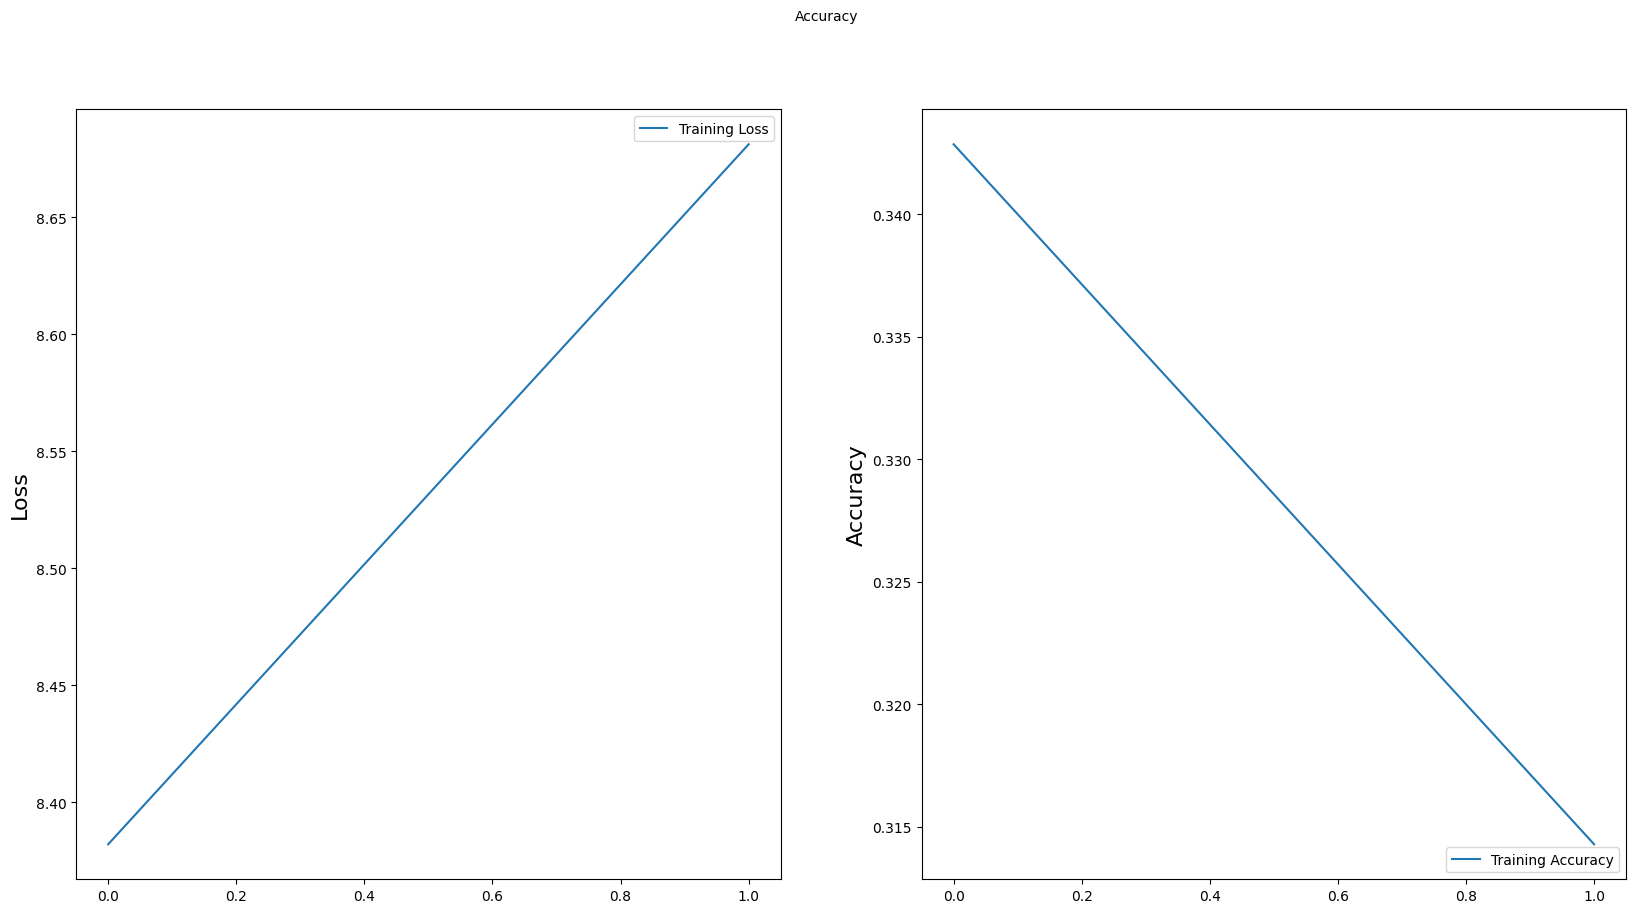

In [23]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Accuracy', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.savefig(testName+'/training_history.png')
plt.show()

15/15 [==============================] - 1s 49ms/step
Predictions:
{0: 0, 1: 15, 2: 0}
Actual answers:
{0: 4, 1: 7, 2: 4}


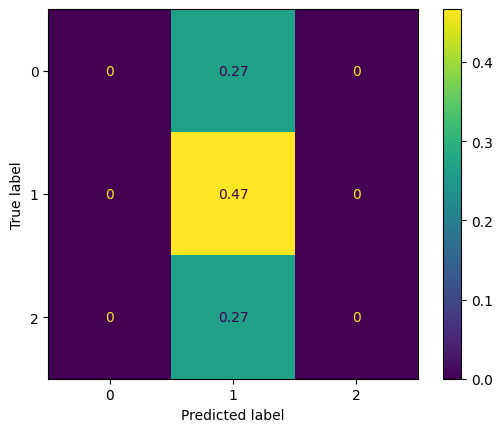

In [30]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

predictions = model.predict(xTest, batch_size=1)
y_predict = np.argmax(predictions,axis=1)
predicts = {0:0,1:0,2:0}
for pred in y_predict:
    predicts[pred]+=1
print('Predictions:')
print(predicts)

ans = {0:0,1:0,2:0}
for pred in yTest:
    ans[pred]+=1
print('Actual answers:')
print(ans)

result = confusion_matrix(yTest,y_predict,normalize='pred')
disp = ConfusionMatrixDisplay(result)
disp.plot()
plt.savefig(testName+'/confusion_matrix.png')
plt.show()

accuracy = accuracy_score(yTest, y_predict)
f1 = f1_score(yTest, y_predict, average='weighted')  # Use 'weighted' for multiclass classification
recall = recall_score(yTest, y_predict, average='weighted')  # Use 'weighted' for multiclass classification


testingMetrics = {'Accuracy':accuracy, 'F1 Score':f1, 'Recall':recall}
file = open(testName+'/testingMetrics.txt','w')
for key, value in testingMetrics.items():
    file.write(f'{key}: {value}\n')
file.close()


